/home/ahnitz/projects/env/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ahnitz/projects/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


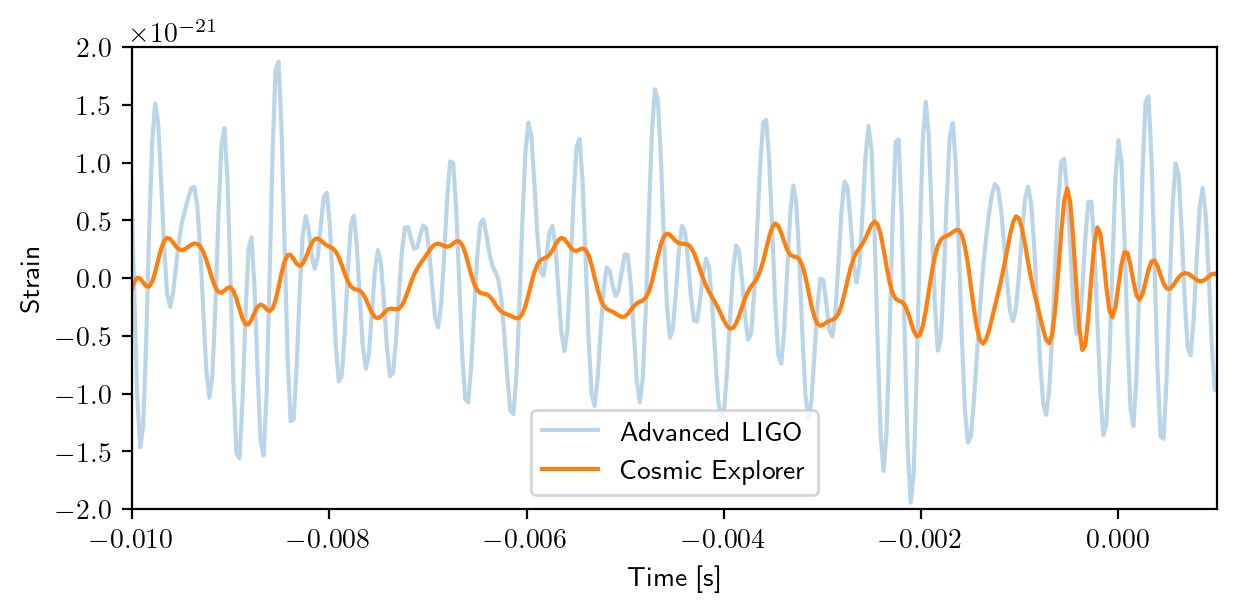

In [19]:
from pycbc.noise.reproduceable import colored_noise
import pycbc.psd
import pycbc.catalog
from pycbc.waveform import get_td_waveform

dur = 8
sr = 8192
flow = 5.2
df = 1.0 / dur
tlen = sr * dur
flen = tlen // 2 + 1
time = -50

ligo = pycbc.psd.aLIGOZeroDetHighPower(flen, df, flow)
ligo_noise = colored_noise(ligo, time, time + 64,
                      sample_rate=8192,
                      low_frequency_cutoff=flow,
                      )

ce_40k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)
noise = colored_noise(ce_40k_base, time, time + 64,
                      sample_rate=8192,
                      low_frequency_cutoff=flow,
                      )

hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=1.4, 
                         mass2=1.4, f_lower=20, delta_t=noise.delta_t,
                         distance=40
                        )

itime = time + 50
hp.start_time += itime

noise = noise.inject(hp).to_frequencyseries().to_timeseries(delta_t=1.0/32768)
noise = noise.highpass_fir(100, 512)

ligo_noise = ligo_noise.inject(hp).highpass_fir(100, 512).to_frequencyseries().to_timeseries(delta_t=1.0/32768)

from matplotlib import pyplot as plt

plt.figure(figsize=(7, 3), dpi=200)
plt.rc('text', usetex=True)
ligo_noise.plot(label='Advanced LIGO', alpha=0.3)
noise.plot(label='Cosmic Explorer')
plt.xlim(itime - .01, itime + 0.001 )
plt.ylim(-2e-21, 2e-21)
plt.ylabel('Strain')
plt.xlabel('Time [s]')
plt.legend()